<a href="https://colab.research.google.com/github/deepakri201/mr_seg/blob/main/staple_and_agreement_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experimenting with the STAPLE algorithm and with displaying heat maps of the agreement

In [12]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "idc-external-018" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Environment setup

In [24]:
import os
import sys
import time
import json
import subprocess
import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# SimpleITK
!pip install simpleITK
import SimpleITK as sitk

In [15]:
from google.cloud import bigquery
from google.cloud import storage
import pandas as pd
from natsort import natsorted, ns


In [16]:
!pip install nibabel
import nibabel as nib
from functools import partial
from tqdm import tqdm


In [17]:
from pathlib import Path


In [18]:
# gcsfuse setup
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0   9628      0 --:--:-- --:--:-- --:--:--  9669
OK
48 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: http://packages.cloud.google.com/apt/dists/gcsfuse-bionic/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
gcsfuse is already the newest version (2.3.0).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.


In [19]:
!mkdir synthseg
!gcsfuse --implicit-dirs synthseg synthseg

mkdir: cannot create directory ‘synthseg’: File exists
{"timestamp":{"seconds":1719596996,"nanos":203251941},"severity":"INFO","message":"Start gcsfuse/2.3.0 (Go version go1.22.4) for app \"\" using mount point: /content/synthseg\n"}
{"timestamp":{"seconds":1719596996,"nanos":203608590},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"MaxRetryDuration\":-1000000000,\

# STAPLE experiments

In [33]:
main_directory = "/content/synthseg/"
main_results_directory = "/content/synthseg/validation/project_week_2024_benchmarking/amos22_mr_training_split_results"

image_filename = os.path.join(main_directory, "validation", "amos", "processed", "mr_images_train", "amos_0594.nii.gz")

gt_filename = os.path.join(main_directory, "validation", "amos", "processed", "mr_labels_train", "amos_0594.nii.gz")
synthseg_filename = os.path.join(main_results_directory, "synthetic_results", "amos_0594_synthseg.nii.gz")
totalsegmentator_filename = os.path.join(main_results_directory, "validation_results_totalseg_mri", "amos22_mr_train", "prediction_results_formatted", "amos_0594.nii.gz")
mrsegmentator_filename = os.path.join(main_results_directory, "validation_results_mrsegmentator_mri", "amos22_mr_train", "prediction_results", "amos_0594_seg.nii.gz")

label_names = ["spleen", "kidney_right", "kidney_left", "gallbladder", "liver", "stomach", "pancreas", "adrenal_gland_right", "adrenal_gland_left", "small_bowel", "duodenum", "colon"]
label_ids_synthseg = [1, 2, 3, 4, 5, 6, 10, 11, 12, 55, 56, 57]
label_ids_totalsegmentator = [1, 2, 3, 4, 5, 6, 10, 11, 12, 55, 56, 57]
label_ids_mrsegmentator = [1, 2, 3, 4, 5, 6, 7, 8, 9, 21, 22, 23]

label_dict_synthseg = dict(zip(label_names,label_ids_synthseg))
label_dict_totalsegmentator = dict(zip(label_names, label_ids_totalsegmentator))
label_dict_mrsegmentator = dict(zip(label_names, label_ids_mrsegmentator))


In [34]:
slice_index = 250
label_name = "liver"

# get the correct label_ids
label_id_synthseg = label_dict_synthseg.get(label_name)
label_id_totalsegmentator = label_dict_totalsegmentator.get(label_name)
label_id_mrsegmentator = label_dict_mrsegmentator.get(label_name)

print('label_name: ' + str(label_name))
print('label_id_synthseg: ' + str(label_id_synthseg))
print('label_id_totalsegmentator: ' + str(label_id_totalsegmentator))
print('label_id_mrsegmentator: ' + str(label_id_mrsegmentator))


label_name: liver
label_id_synthseg: 5
label_id_totalsegmentator: 5
label_id_mrsegmentator: 5


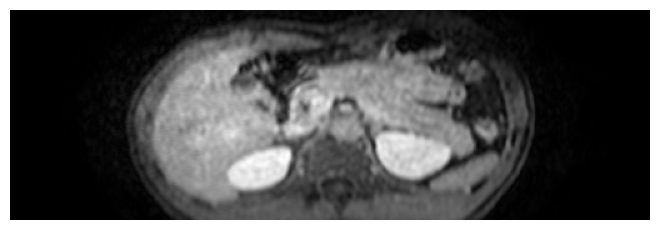

In [35]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load your 3D image
img = nib.load(image_filename)

# Get the data from the image
img_data = img.get_fdata()

# Get the pixel spacing from the image metadata
pixel_spacing = img.header.get_zooms()
pixel_spacing_x, pixel_spacing_y, _ = pixel_spacing  # Assume we're looking at a single slice along the z-axis

# Extract a 2D slice from the 3D image (e.g., the middle slice)
# slice_index = img_data.shape[2] // 2
image_slice = img_data[:, :, slice_index]

# Get the dimensions of the slice
height, width = image_slice.shape

# Calculate the figure size to maintain the aspect ratio
fig_width = width * pixel_spacing_x
fig_height = height * pixel_spacing_y

# Create a figure with the appropriate size
# fig = plt.figure(figsize=(fig_width / 100, fig_height / 100), dpi=100)  # divide by 100 to convert to inches for figsize
fig = plt.figure()

# Display the image slice
ax = fig.add_axes([0, 0, 1, 1])  # Add axes to the figure
ax.imshow(np.rot90(image_slice,k=3), cmap='gray', origin='lower')  # Use gray colormap for medical images
ax.set_axis_off()  # Hide the axes

plt.show()


In [36]:
# load our three manual segmentations
seg1 = nib.load(synthseg_filename).get_fdata()[:,:,slice_index]
seg2 = nib.load(totalsegmentator_filename).get_fdata()[:,:,slice_index]
seg3 = nib.load(mrsegmentator_filename).get_fdata()[:,:,slice_index]

# only get where each equals the appropriate label_id
ind = np.where(seg1==label_id_synthseg)
seg1 = np.zeros(seg1.shape)
seg1[ind] = 1

ind = np.where(seg2==label_id_totalsegmentator)
seg2 = np.zeros(seg2.shape)
seg2[ind] = 1

ind = np.where(seg3==label_id_mrsegmentator)
seg3 = np.zeros(seg3.shape)
seg3[ind] = 1

# STAPLE is availabe as a SITK package. To use, convert segmentations to SITK image objects
seg1_sitk = sitk.GetImageFromArray(seg1.astype(np.int16)) # STAPLE requires we cast into int16 arrays
seg2_sitk = sitk.GetImageFromArray(seg2.astype(np.int16))
seg3_sitk = sitk.GetImageFromArray(seg3.astype(np.int16))
seg_stack = [seg1_sitk, seg2_sitk, seg3_sitk]

# Run STAPLE algorithm
STAPLE_seg_sitk = sitk.STAPLE(seg_stack, 1.0 ) # 1.0 specifies the foreground value

# convert back to numpy array
STAPLE_seg = sitk.GetArrayFromImage(STAPLE_seg_sitk)

In [39]:
# Apply the STAPLE algorithm
staple_filter = sitk.STAPLEImageFilter()
staple_result = staple_filter.Execute(seg_stack)

# Get the estimated ground truth from STAPLE
staple_array = sitk.GetArrayFromImage(staple_result)

# Performance metrics: Sensitivity and Specificity for each input segmentation
sensitivities = staple_filter.GetSensitivity()
specificities = staple_filter.GetSpecificity()

print(sensitivities)
print(specificities)

(0.9724786808454929, 0.951094744408619, 0.9983915809475543)
(0.9987292990701301, 0.9998504374334969, 0.9953372734010101)


In [ ]:
# # Combine masks to show overlap and differences
# combined_mask = seg1 + 2*seg2 + 4*seg3
# num_values_heat = len(np.unique(combined_mask))
# # Define a colormap
# cmap_combine_mask = plt.cm.get_cmap('viridis', num_values_heat)  # 8 discrete colors

<ipython-input-102-e418f8d794e3>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_combine_mask = plt.cm.get_cmap('viridis', num_values_heat)  # 8 discrete colors


([], [])

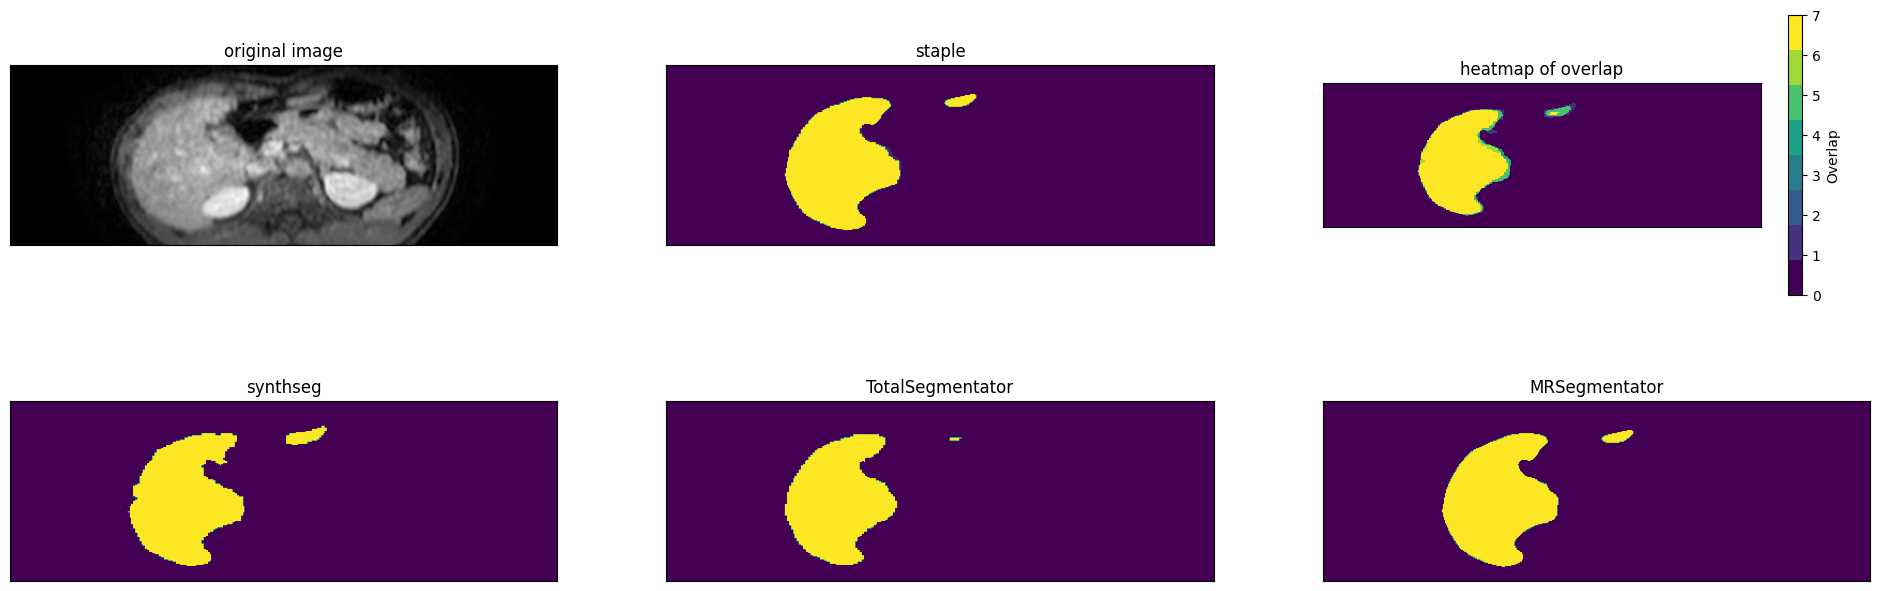

In [ ]:
# # Plot the image, three segmentations, and the staple

# # fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 16))
# # fig.tight_layout()

# plt.figure(figsize=(24,8))
# plt.subplot(2,3,1)
# plt.imshow(np.rot90(image_slice,k=3), cmap='gray')
# plt.gca().invert_yaxis()
# plt.title('original image')
# plt.xticks([])
# plt.yticks([])

# plt.subplot(2,3,2),
# plt.imshow(np.rot90(STAPLE_seg,k=3))
# plt.gca().invert_yaxis()
# plt.title('staple')
# plt.xticks([])
# plt.yticks([])

# plt.subplot(2,3,3)
# plt.imshow(np.rot90(combined_mask,k=3), cmap=cmap_combine_mask, interpolation='nearest')
# plt.colorbar(ticks=range(num_values_heat), label='Overlap')
# plt.gca().invert_yaxis()
# plt.title('heatmap of overlap')
# plt.xticks([])
# plt.yticks([])

# plt.subplot(2,3,4),
# plt.imshow(np.rot90(seg1,k=3))
# plt.gca().invert_yaxis()
# plt.title('synthseg')
# plt.xticks([])
# plt.yticks([])

# plt.subplot(2,3,5),
# plt.imshow(np.rot90(seg2,k=3))
# plt.gca().invert_yaxis()
# plt.title('TotalSegmentator')
# plt.xticks([])
# plt.yticks([])

# plt.subplot(2,3,6),
# plt.imshow(np.rot90(seg3,k=3))
# plt.gca().invert_yaxis()
# plt.title('MRSegmentator')
# plt.xticks([])
# plt.yticks([])


# Create a 3D heatmap

In [27]:
main_directory = "/content/synthseg/"
main_results_directory = "/content/synthseg/validation/project_week_2024_benchmarking/amos22_mr_training_split_results"

image_filename = os.path.join(main_directory, "validation", "amos", "processed", "mr_images_train", "amos_0594.nii.gz")

gt_filename = os.path.join(main_directory, "validation", "amos", "processed", "mr_labels_train", "amos_0594.nii.gz")
synthseg_filename = os.path.join(main_results_directory, "synthetic_results", "amos_0594_synthseg.nii.gz")
totalsegmentator_filename = os.path.join(main_results_directory, "validation_results_totalseg_mri", "amos22_mr_train", "prediction_results_formatted", "amos_0594.nii.gz")
mrsegmentator_filename = os.path.join(main_results_directory, "validation_results_mrsegmentator_mri", "amos22_mr_train", "prediction_results", "amos_0594_seg.nii.gz")

label_names = ["spleen", "kidney_right", "kidney_left", "gallbladder", "liver", "stomach", "pancreas", "adrenal_gland_right", "adrenal_gland_left", "small_bowel", "duodenum", "colon"]
label_ids_synthseg = [1, 2, 3, 4, 5, 6, 10, 11, 12, 55, 56, 57]
label_ids_totalsegmentator = [1, 2, 3, 4, 5, 6, 10, 11, 12, 55, 56, 57]
label_ids_mrsegmentator = [1, 2, 3, 4, 5, 6, 7, 8, 9, 21, 22, 23]

label_dict_synthseg = dict(zip(label_names,label_ids_synthseg))
label_dict_totalsegmentator = dict(zip(label_names, label_ids_totalsegmentator))
label_dict_mrsegmentator = dict(zip(label_names, label_ids_mrsegmentator))


In [32]:
num_labels = len(label_names)

for n in range(0,num_labels):

  label_name = label_names[n]
  print('*** creating heatmap for the segment: ' + str(label_name))

  combined_mask_output_filename = os.path.join('/content', label_name + ".nii.gz")
  print('combined_mask_output_filename: ' + str(combined_mask_output_filename))

  # get the correct label_ids
  label_id_synthseg = label_dict_synthseg.get(label_name)
  label_id_totalsegmentator = label_dict_totalsegmentator.get(label_name)
  label_id_mrsegmentator = label_dict_mrsegmentator.get(label_name)

  print('label_name: ' + str(label_name))
  print('label_id_synthseg: ' + str(label_id_synthseg))
  print('label_id_totalsegmentator: ' + str(label_id_totalsegmentator))
  print('label_id_mrsegmentator: ' + str(label_id_mrsegmentator))

  # load our three manual segmentations
  seg1 = nib.load(synthseg_filename).get_fdata()
  seg2 = nib.load(totalsegmentator_filename).get_fdata()
  seg3 = nib.load(mrsegmentator_filename).get_fdata()

  nii = nib.load(synthseg_filename)

  # only get where each equals the appropriate label_id
  ind = np.where(seg1==label_id_synthseg)
  seg1 = np.zeros(seg1.shape)
  seg1[ind] = 1

  ind = np.where(seg2==label_id_totalsegmentator)
  seg2 = np.zeros(seg2.shape)
  seg2[ind] = 1

  ind = np.where(seg3==label_id_mrsegmentator)
  seg3 = np.zeros(seg3.shape)
  seg3[ind] = 1

  # combine the masks
  combined_mask = seg1 + seg2 + seg3
  num_values_heat = len(np.unique(combined_mask))

  print(np.unique(combined_mask))

  combined_mask_nii = nib.Nifti1Image(combined_mask, affine = nii.affine, header=nii.header)
  nib.save(combined_mask_nii, combined_mask_output_filename)

*** creating heatmap for the segment: spleen
combined_mask_output_filename: /content/spleen.nii.gz
label_name: spleen
label_id_synthseg: 1
label_id_totalsegmentator: 1
label_id_mrsegmentator: 1
[0. 1. 2. 3.]
*** creating heatmap for the segment: kidney_right
combined_mask_output_filename: /content/kidney_right.nii.gz
label_name: kidney_right
label_id_synthseg: 2
label_id_totalsegmentator: 2
label_id_mrsegmentator: 2
[0. 1. 2. 3.]
*** creating heatmap for the segment: kidney_left
combined_mask_output_filename: /content/kidney_left.nii.gz
label_name: kidney_left
label_id_synthseg: 3
label_id_totalsegmentator: 3
label_id_mrsegmentator: 3
[0. 1. 2. 3.]
*** creating heatmap for the segment: gallbladder
combined_mask_output_filename: /content/gallbladder.nii.gz
label_name: gallbladder
label_id_synthseg: 4
label_id_totalsegmentator: 4
label_id_mrsegmentator: 4
[0. 1. 2. 3.]
*** creating heatmap for the segment: liver
combined_mask_output_filename: /content/liver.nii.gz
label_name: liver
label

In [25]:
# # Combine masks to show overlap and differences
# # combined_mask = seg1 + 2*seg2 + 4*seg3

# combined_mask = seg1 + seg2 + seg3
# num_values_heat = len(np.unique(combined_mask))
# # Define a colormap
# cmap_combine_mask = plt.cm.get_cmap('viridis', num_values_heat)  # 8 discrete colors

<ipython-input-25-6413779dc46d>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_combine_mask = plt.cm.get_cmap('viridis', num_values_heat)  # 8 discrete colors


# Dice score chatgpt

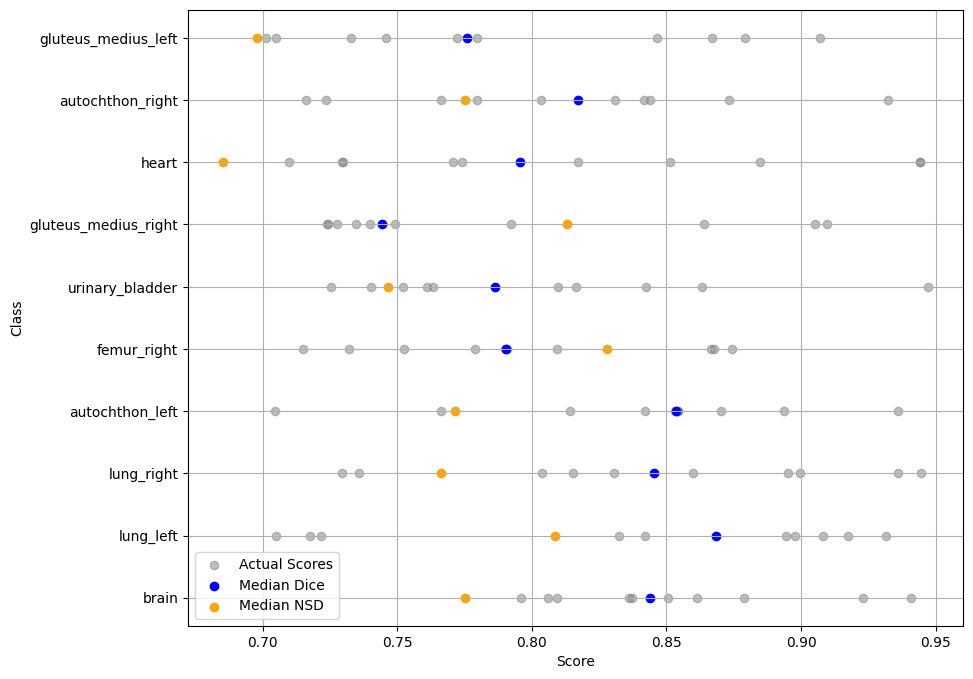

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample data for 10 segments and multiple subjects
np.random.seed(0)  # For reproducibility

segments = [
    'brain', 'lung_left', 'lung_right', 'autochthon_left', 'femur_right',
    'urinary_bladder', 'gluteus_medius_right', 'heart', 'autochthon_right', 'gluteus_medius_left'
]

# Create random data for Dice and NSD scores for 10 subjects per segment
data = {
    'Class': np.repeat(segments, 10),
    'Dice': np.random.uniform(0.7, 0.95, 100),
    'NSD': np.random.uniform(0.6, 0.9, 100)
}

# Create DataFrame
df = pd.DataFrame(data)

# Calculate median scores for Dice and NSD
median_scores = df.groupby('Class').median().reset_index()

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot for actual Dice and NSD scores
ax.scatter(df['Dice'], df['Class'], color='grey', alpha=0.5, label='Actual Scores')

# Scatter plot for median Dice
ax.scatter(median_scores['Dice'], median_scores['Class'], color='blue', label='Median Dice')

# Scatter plot for median NSD
ax.scatter(median_scores['NSD'], median_scores['Class'], color='orange', label='Median NSD')

# Add legend
ax.legend()

# Add grid
ax.grid(True)

# Add labels
ax.set_xlabel('Score')
ax.set_ylabel('Class')

plt.show()


ValueError: x and y must be the same size

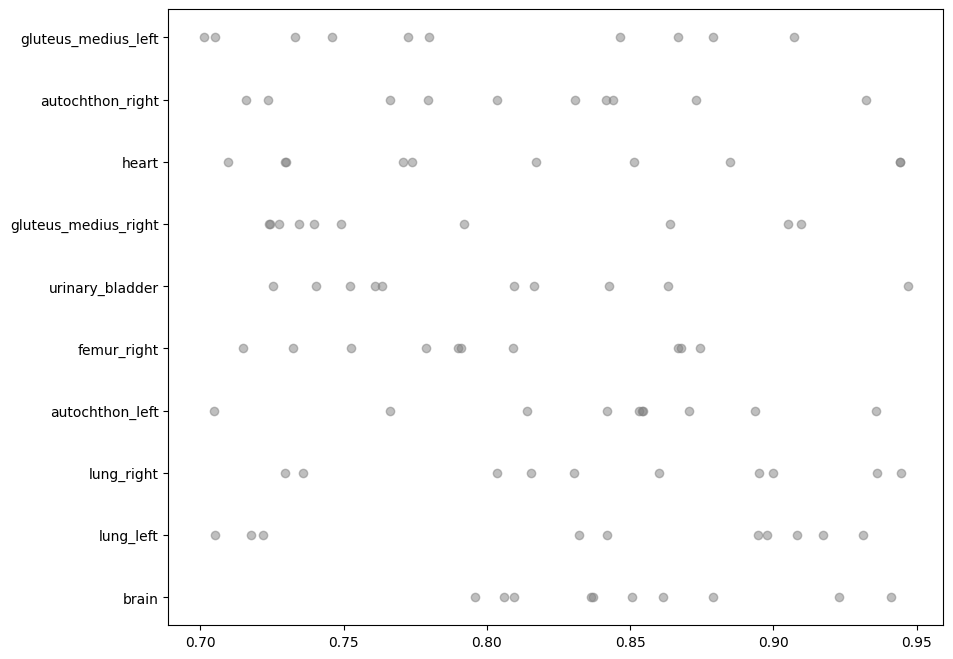

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample data for 10 segments and multiple subjects
np.random.seed(0)  # For reproducibility

segments = [
    'brain', 'lung_left', 'lung_right', 'autochthon_left', 'femur_right',
    'urinary_bladder', 'gluteus_medius_right', 'heart', 'autochthon_right', 'gluteus_medius_left'
]

# Create random data for Dice and NSD scores for 10 subjects per segment for two sets
data1 = {
    'Class': np.repeat(segments, 10),
    'Dice': np.random.uniform(0.7, 0.95, 100),
    'NSD': np.random.uniform(0.6, 0.9, 100)
}

data2 = {
    'Class': np.repeat(segments, 10),
    'Dice': np.random.uniform(0.65, 0.9, 100),
    'NSD': np.random.uniform(0.55, 0.85, 100)
}

# Create DataFrames
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

# Calculate median scores for Dice and NSD for both sets
median_scores1 = df1.groupby('Class').median().reset_index()
median_scores2 = df2.groupby('Class').median().reset_index()

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Offset the second set of points slightly downwards
offset = 0.2
class_labels = np.arange(len(segments))

# Scatter plot for actual Dice and NSD scores for both sets
ax.scatter(df1['Dice'], df1['Class'], color='grey', alpha=0.5, label='Actual Scores Set 1')
ax.scatter(df2['Dice'], class_labels - offset, color='lightgrey', alpha=0.5, label='Actual Scores Set 2', marker='x')

ax.scatter(df1['NSD'], df1['Class'], color='grey', alpha=0.5)
ax.scatter(df2['NSD'], class_labels - offset, color='lightgrey', alpha=0.5, marker='x')

# Scatter plot for median Dice and NSD for both sets with offset
ax.scatter(median_scores1['Dice'], median_scores1['Class'], color='blue', label='Median Dice Set 1')
ax.scatter(median_scores1['NSD'], median_scores1['Class'], color='orange', label='Median NSD Set 1')

ax.scatter(median_scores2['Dice'], class_labels - offset, color='blue', label='Median Dice Set 2', marker='x')
ax.scatter(median_scores2['NSD'], class_labels - offset, color='orange', label='Median NSD Set 2', marker='x')

# Add legend
ax.legend()

# Add grid
ax.grid(True)

# Add labels
ax.set_xlabel('Score')
ax.set_ylabel('Class')

# Adjust yticks to reflect the offset
ax.set_yticks(np.arange(len(segments)))
ax.set_yticklabels(segments)

plt.show()
